# Litteraturbanken Author 
version 1.15 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      Open question how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> we should not create everyone in Wikidata 
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
We need CC0 to import data in Wikidata (see [Wikidata:Licensing](https://www.wikidata.org/wiki/Wikidata:Licensing)) e.g. if we should add all books as objects in Wikidata with no text and create links to Litteraturbanken then fields like below need to be [CC-0](https://creativecommons.org/share-your-work/public-domain/cc0/)  
* Författare
* Verk
* Libris-id 
* förlaga	
* eid	
* Införd	
* Länk i klartext	
* Epub	
* Källa

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-10-07 15:51:36.645312


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
365,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1600563813891,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3656 non-null   object        
 1   wd_hos_Litteraturbanken  1418 non-null   object        
 2   authorid_norm            3656 non-null   object        
 3   show                     3656 non-null   bool          
 4   updated                  2989 non-null   datetime64[ns]
 5   imported                 2989 non-null   datetime64[ns]
 6   librisid                 1929 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 175.1+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2288
False    1368
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 1 to 3655
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2288 non-null   object        
 1   wd_hos_Litteraturbanken  1318 non-null   object        
 2   authorid_norm            2288 non-null   object        
 3   show                     2288 non-null   bool          
 4   updated                  1837 non-null   datetime64[ns]
 5   imported                 1837 non-null   datetime64[ns]
 6   librisid                 1212 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 127.4+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:10]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,WägnerE,Q270468,WagnerE,True,2020-09-22,2010-02-17,0xbdgmxj0thr95n
2,JörlinE,NaN,JorlinE,True,2020-09-21,2020-09-21,NaN
3,FechtPM,NaN,FechtPM,True,2020-09-21,2020-09-21,NaN
4,RichardsonJ,NaN,RichardsonJ,True,2020-09-21,2020-09-21,NaN
5,BrattI,NaN,BrattI,True,2020-09-21,2020-09-21,hftwzbq12j7vcjz
6,FrondinE,NaN,FrondinE,True,2020-09-21,2020-09-21,zw9dkwmh3fc7gdr
7,LaurentiusPetriGothus,NaN,LaurentiusPetriGothus,True,2020-09-21,2020-09-21,64jlpf6q2k76524
8,BerglundD,NaN,BerglundD,True,2020-09-21,2020-09-21,NaN
9,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:10]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd
1,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4
2,JohanIII,NaN,JohanIII,True,2020-09-21,2020-09-21,ljx016344bl6mdn
3,WestdahlP,NaN,WestdahlP,True,2020-09-21,2020-09-21,NaN
4,WahlenbergG,NaN,WahlenbergG,True,2020-09-21,2020-09-21,dbqspmqx0z27d0d
5,AckeJAG,NaN,AckeJAG,True,2020-09-21,2020-09-21,tr577tpc0k0tfc9
6,HolthusenCJ,NaN,HolthusenCJ,True,2020-09-21,2020-09-21,NaN
7,TollinF,NaN,TollinF,True,2020-09-21,2020-09-21,53hkn33p1btlh7l
8,BäckströmPO,NaN,BackstromPO,True,2020-09-21,2020-09-21,53hlqskp2qx9r38
9,DahlgrenL,NaN,DahlgrenL,True,2020-09-21,2020-09-21,42gjklkn56sfzxw


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1666 non-null   object
 1   authorid    1666 non-null   object
dtypes: object(2)
memory usage: 26.2+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    0
authorid      0
dtype: int64

## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [16]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:10]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1666,NaN,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd,Litterturbanken_only
1633,Q270468,WägnerE,Q270468,WagnerE,True,2020-09-22,2010-02-17,0xbdgmxj0thr95n,both
641,Q5785048,HallmanJG,NaN,HallmanJG,True,2020-09-21,2020-09-21,nl024sx63m6jpz4,both
1588,Q16616102,WestdahlP,NaN,WestdahlP,True,2020-09-21,2020-09-21,NaN,both
776,Q52944,JohanIII,NaN,JohanIII,True,2020-09-21,2020-09-21,ljx016344bl6mdn,both
1558,Q533348,WahlenbergG,NaN,WahlenbergG,True,2020-09-21,2020-09-21,dbqspmqx0z27d0d,both
289,Q5591755,BäckströmPO,NaN,BackstromPO,True,2020-09-21,2020-09-21,53hlqskp2qx9r38,both
888,Q935691,LaurentiusPetriGothus,NaN,LaurentiusPetriGothus,True,2020-09-21,2020-09-21,64jlpf6q2k76524,both
371,Q4944000,DahlgrenL,NaN,DahlgrenL,True,2020-09-21,2020-09-21,42gjklkn56sfzxw,both
1252,Q6070779,RichardsonJ,NaN,RichardsonJ,True,2020-09-21,2020-09-21,NaN,both


In [17]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 1666 to 2300
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1666 non-null   object        
 1   authorid                 2301 non-null   object        
 2   wd_hos_Litteraturbanken  1319 non-null   object        
 3   authorid_norm            2289 non-null   object        
 4   show                     2289 non-null   object        
 5   updated                  1838 non-null   datetime64[ns]
 6   imported                 1838 non-null   datetime64[ns]
 7   librisid                 1212 non-null   object        
 8   WD_Litteraturbanken      2301 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 179.8+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [18]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1654
Litterturbanken_only     635
WD_only                   12
Name: WD_Litteraturbanken, dtype: int64

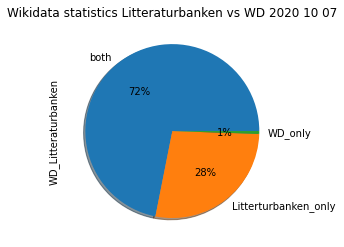

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [20]:
mergeCheckNumber

both                    1654
Litterturbanken_only     635
WD_only                   12
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [21]:
#mergewithLibris

In [22]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [23]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1212 entries, 1666 to 1251
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1180 non-null   object        
 1   authorid                 1212 non-null   object        
 2   wd_hos_Litteraturbanken  1070 non-null   object        
 3   authorid_norm            1212 non-null   object        
 4   show                     1212 non-null   object        
 5   updated                  1212 non-null   datetime64[ns]
 6   imported                 1212 non-null   datetime64[ns]
 7   librisid                 1212 non-null   object        
 8   WD_Litteraturbanken      1212 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 94.7+ KB


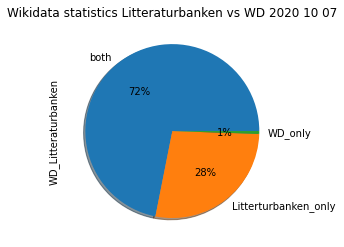

In [24]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [25]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 186 to 1658
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               12 non-null     object        
 1   authorid                 12 non-null     object        
 2   wd_hos_Litteraturbanken  0 non-null      object        
 3   authorid_norm            0 non-null      object        
 4   show                     0 non-null      object        
 5   updated                  0 non-null      datetime64[ns]
 6   imported                 0 non-null      datetime64[ns]
 7   librisid                 0 non-null      object        
 8   WD_Litteraturbanken      12 non-null     object        
dtypes: datetime64[ns](2), object(7)
memory usage: 960.0+ bytes


In [26]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288 entries, 0 to 2287
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2288 non-null   object        
 1   wd_hos_Litteraturbanken  1318 non-null   object        
 2   authorid_norm            2288 non-null   object        
 3   show                     2288 non-null   bool          
 4   updated                  1837 non-null   datetime64[ns]
 5   imported                 1837 non-null   datetime64[ns]
 6   librisid                 1212 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 109.6+ KB


In [27]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 12 non-null     object        
 1   authorid_x                 12 non-null     object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        12 non-null     object        
 9   authorid_y                 2288 non-null   object        
 10  wd_hos_Litteraturbanken_y  1318 non-null   object        
 11  authorid_norm_y            2288 non-null   object        
 12  show_y

In [28]:
df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
3574,WåhlinK,WahlinK,"{'date': '1861', 'plain': '1861'}",b8df8ca649f60fc148478e511156e51c,1600563816844,"{'date': '1937', 'plain': '1937'}",author,Karl Wåhlin,male,2014-02-11,None,vs689v6d41dplmt,"Wåhlin, Karl",None,False,False,Wåhlin,2019-10-16,"{'birthplace': [13.199164196, 55.708313018], '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3575,WåhlinKr,WahlinKr,"{'date': '1942', 'plain': '1942'}",97c8081e467fdac69211feee0e73fbe5,1600563816853,"{'date': '1995', 'plain': '1995'}",author,Kristian Wåhlin,male,NaN,None,NaN,"Wåhlin, Kristian",None,False,False,Wåhlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df[df['authorid'].str.contains("BjörkmanE")] 

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
398,BjörkmanE,BjorkmanE,"{'date': '1876', 'plain': '1876'}",873e80616426266c05b92c13bf1bb788,1600563813912,{'plain': '1960'},author,Evy Björkman,female,2018-10-25,None,NaN,"Björkman, Evy",None,False,False,Björkman,2018-10-25,NaN,NaN,{'intro': '<p>EVY BJÖRKMAN var en aktiv föreni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [30]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,authorid_y,WikidataID,show_y,authorid_x
0,DahlénT,Q99771903,True,DahlenT
1,FjørtoftK,Q99871759,True,FjortoftK
2,ForsåsScottH,Q99872638,True,ForsasScottH


In [31]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,WikidataID,authorid,Littbank
186,Q68117,BirchPfeifferC,link
199,Q11859217,BjörkmanE,link
283,Q14932468,ButenschönA,link
367,Q99771903,DahlenT,link
504,Q99871759,FjortoftK,link
516,Q99872638,ForsasScottH,link
730,Q99751230,HornströmM,link
1264,Q16946439,RomanusAlfvénAC,link
1375,Q3527629,SjödinS,link
1513,Q4458078,TirénG,link


In [32]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [33]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 3 non-null      object        
 1   authorid_x                 3 non-null      object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        3 non-null      object        
 9   Littbank                   3 non-null      object        
 10  authorid_y                 3 non-null      object        
 11  wd_hos_Litteraturbanken_y  0 non-null      object        
 12  authorid_nor

In [34]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q99771903,DahlenT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,DahlénT,NaN,DahlenT,True,2018-01-18,2018-01-18,NaN,both
1,Q99871759,FjortoftK,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,FjørtoftK,NaN,FjortoftK,True,2014-03-14,2014-03-14,NaN,both
2,Q99872638,ForsasScottH,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,ForsåsScottH,NaN,ForsasScottH,True,2018-02-05,2014-02-11,NaN,both


In [35]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [36]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1654
Litterturbanken_only     635
WD_only                   12
Name: WD_Litteraturbanken, dtype: int64

In [37]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635 entries, 1666 to 2300
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 635 non-null    object        
 2   wd_hos_Litteraturbanken  8 non-null      object        
 3   authorid_norm            635 non-null    object        
 4   show                     635 non-null    object        
 5   updated                  353 non-null    datetime64[ns]
 6   imported                 353 non-null    datetime64[ns]
 7   librisid                 32 non-null     object        
 8   WD_Litteraturbanken      635 non-null    object        
dtypes: datetime64[ns](2), object(7)
memory usage: 49.6+ KB


In [38]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                  0
authorid                   32
wd_hos_Litteraturbanken     2
authorid_norm              32
show                       32
updated                    32
imported                   32
librisid                   32
WD_Litteraturbanken        32
dtype: int64

In [39]:
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()]

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1666,NaN,Eugénie,NaN,Eugenie,True,2022-02-22,2022-02-22,vs6888xd2lx9tfd,Litterturbanken_only
1910,NaN,HelvigA,NaN,HelvigA,True,2020-08-26,2018-01-25,gdsvz0n00qsc5bb,Litterturbanken_only
1674,NaN,BerglindhU,NaN,BerglindhU,True,2020-06-22,2020-06-22,dbqswjtx2csh0hp,Litterturbanken_only
1675,NaN,RuheA,NaN,RuheA,True,2020-05-25,2020-05-25,pm1353r73nxlwkf,Litterturbanken_only
1904,NaN,GödeckePA,NaN,GodeckePA,True,2020-05-25,2018-01-28,nl037b062czcjg4,Litterturbanken_only
1897,NaN,AgnesdotterC,NaN,AgnesdotterC,True,2020-05-25,2018-02-22,vs69h4gd0g62md4,Litterturbanken_only
1677,NaN,MannheimerO,NaN,MannheimerO,True,2020-05-04,2020-05-04,gdsw4zr01sjm4d8,Litterturbanken_only
1908,NaN,AhnfeltO,NaN,AhnfeltO,True,2020-04-27,2018-01-28,c9prscmw1dg1rd4,Litterturbanken_only
1678,NaN,EngeströmL,NaN,EngestromL,True,2020-04-27,2020-04-27,c9prsplw3tz4t23,Litterturbanken_only
1852,NaN,FribergL,NaN,FribergL,True,2020-04-27,2018-09-24,20dgjq3l559b20l,Litterturbanken_only


### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [40]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [41]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1659
right_only    1361
both             7
Name: _merge, dtype: int64

In [42]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy()  
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False
# BirchPfeifferC BjörkmanE ButenschönA RomanusAlfvénAC SjödinS TirénG ÅströmP

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,_merge,Littbank
186,Q68117,BirchPfeifferC,NaN,BirchPfeifferC,False,2019-05-14,2018-10-25,NaN,both,link Litteraturbanken
199,Q11859217,BjörkmanE,NaN,BjorkmanE,False,2018-10-25,2018-10-25,NaN,both,link Litteraturbanken
283,Q14932468,ButenschönA,Q14932468,ButenschonA,False,2018-10-25,2018-10-25,NaN,both,link Litteraturbanken
1264,Q16946439,RomanusAlfvénAC,Q16946439,RomanusAlfvenAC,False,NaT,NaT,NaN,both,link Litteraturbanken
1375,Q3527629,SjödinS,Q3527629,SjodinS,False,2019-10-16,2010-09-28,1zcfhwvk50wff8f,both,link Litteraturbanken
1513,Q4458078,TirénG,Q4458078,TirenG,False,2019-10-16,2014-02-11,31fhj5wm4rnx095,both,link Litteraturbanken
1658,Q2063496,ÅströmP,Q2063496,AstromP,False,2014-03-17,2014-02-11,NaN,both,link Litteraturbanken


In [43]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 186 to 1658
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               7 non-null      object        
 1   authorid                 7 non-null      object        
 2   wd_hos_Litteraturbanken  5 non-null      object        
 3   authorid_norm            7 non-null      object        
 4   show                     7 non-null      object        
 5   updated                  6 non-null      datetime64[ns]
 6   imported                 6 non-null      datetime64[ns]
 7   librisid                 2 non-null      object        
 8   _merge                   7 non-null      category      
 9   Littbank                 7 non-null      object        
dtypes: category(1), datetime64[ns](2), object(7)
memory usage: 671.0+ bytes


In [44]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Ended:  2020-10-07 15:51:43.156908
Time elapsed (hh:mm:ss.ms) 0:00:06.511987
